In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'MLPModel'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class MLPModel(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(25, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
            )

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = MLPModel().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 3777


In [13]:
# Train model
model, history = sf.train_model(
    model=model,
    dataset_train=subsets['train'],
    dataset_val=subsets['val'],

    # Define loss & optimizer
    loss_function=nn.MSELoss().to(device),
    optimizer=optim.Adam(params=model.parameters(), lr=.01, betas=(.9, .999), weight_decay=0),

    # Define computing device
    device=device,

    # Define training parameters
    epochs=50,
    patience=5,
    delta=0,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True,

    # Define save locations
    save_state_dict_as=f'../models/{model_name}/state_dict.pt',
    save_history_as=f'../models/{model_name}/history.csv'
    )

100%|██████████| 646/646 [00:00<00:00, 1842.44it/s]


Epoch  1/50: RMSE_train: 1,289,104, RMSE_val: 1,249,001


100%|██████████| 646/646 [00:00<00:00, 2067.03it/s]


Epoch  2/50: RMSE_train: 866,250, RMSE_val: 1,049,977


100%|██████████| 646/646 [00:00<00:00, 2014.89it/s]


Epoch  3/50: RMSE_train: 821,691, RMSE_val: 938,435


100%|██████████| 646/646 [00:00<00:00, 2019.76it/s]


Epoch  4/50: RMSE_train: 798,587, RMSE_val: 899,428


100%|██████████| 646/646 [00:00<00:00, 2010.56it/s]


Epoch  5/50: RMSE_train: 783,627, RMSE_val: 896,478


100%|██████████| 646/646 [00:00<00:00, 2041.27it/s]


Epoch  6/50: RMSE_train: 774,243, RMSE_val: 895,006


100%|██████████| 646/646 [00:00<00:00, 2041.67it/s]


Epoch  7/50: RMSE_train: 767,626, RMSE_val: 898,866
EarlyStopping counter: 1 out of 5


100%|██████████| 646/646 [00:00<00:00, 2047.36it/s]


Epoch  8/50: RMSE_train: 763,611, RMSE_val: 898,227
EarlyStopping counter: 2 out of 5


100%|██████████| 646/646 [00:00<00:00, 1996.01it/s]


Epoch  9/50: RMSE_train: 760,866, RMSE_val: 903,289
EarlyStopping counter: 3 out of 5


100%|██████████| 646/646 [00:00<00:00, 2061.42it/s]


Epoch 10/50: RMSE_train: 758,784, RMSE_val: 911,180
EarlyStopping counter: 4 out of 5


100%|██████████| 646/646 [00:00<00:00, 2004.82it/s]

Epoch 11/50: RMSE_train: 756,465, RMSE_val: 910,466
EarlyStopping counter: 5 out of 5
Early stopping condition met


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset        RMSE         MAE   MAPE     R2
--------------------------------------------
train   769250.876  454404.583  0.644  0.620
val     896165.480  522255.146  0.717  0.476
test    926661.252  529333.661  0.702  0.445
--------------------------------------------
total   816254.407  476174.512  0.663  0.571


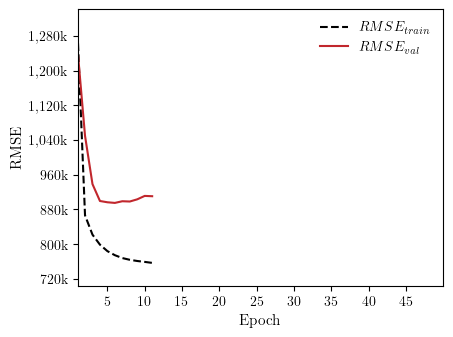

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

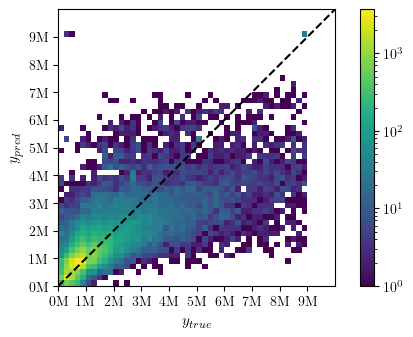

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')